# Task 1: Data Quality Assessment & Recommendations

The original sample comprises of 1,000 records with 11 variables. Initial observation of the sample indicates that there are missing data and outliers in certain variables which require modification to avoid undesirable impact on the model's result. 

Specific findings and recommendations for each variable are presented as below. After implementing modifications, there are 939 records (~94% of the original sample) remaining which could be used for the model.

## 1. Variables not requiring any modifications:

There are no missing data or outliers detected in **Application ID** and **Default in 12 Months.** 

## 2. Variables requiring modifications:

**LTV (Loan to Value), Mortgage Value On Application (Estimate), and Amount at Application:**
- There are 29 records with missing *LTV* data (denoted by "99999999.99") and 10 records with missing *Mortgage Value On Application (Estimate)* data (denoted by "99999999"). Additionally, 3 other records have an *LTV* of less than 1% or more than 2400%. As the model's performance depends on the accuracy of *LTV*, it is recommended that these records be removed from the sample.
- There are 2 records with negative *LTV* which may have been caused by data entry errors in *Amount at Application* (these values are also negative). We will convert these amounts to positive value. 

**Date of Application:** 
- There are 5 records with missing data (0.5% of the sample). *Date of Application* is usually not a direct cause for loan default unless there is a significant economic downturn which can negatively impact a vast number of loan applicants. Therefore, we can impute the missing data with a special value (i.e. "2015-01-01") for future reference.  
- Records that are dated before 2009-01-01 will be removed from the sample. The remaining records are between 2009-01-01 and 2015-01-01.

**Loan Tenor (in months):**
- There are 3 records with missing data. Given that it only represent 0.3% of the sample, we can assume that these applicants have a loan tenor equal to the sample's mean and update them accordingly.

**Age of Applicant** and **Years in Current Job:**
- It follows that applicants should be at least 18 years old. However, there are 83 records where the applicant's age is under 18 and the *Years in Current Job* is exactly 18 years less than *Age of Applicant*, which suggests a substraction was performed for this field rather than gathering the actual information. Since this represents less than 1% of the sample, we will replace *Age of Applicant* with the mean age and the corresponding *Years in Current Job* with "N/A". Other records with negative *Years in Current Job* will also be replaced with "N/A".

**Employment Status, Area,** and **Exposure to Other Banks:**
- Missing data in Employment Status, Area, and Exposure to Other Banks accounts for 14.4%, 1%, and 57% of the sample, respectively. These variables can still be helpful to the model, thus it is recommended to fill them with relevant "Other" or "0".

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_excel('/Users/hoale/Documents/Risk/data.xlsx', index_col=[])
data['Amount at Application'] = data['Amount at Application'].astype(float)
data['Loan Tenor (in months)'] = data['Loan Tenor (in months)'].apply(pd.to_numeric, errors='coerce')
data['Age of Applicant'] = data['Age of Applicant'].apply(pd.to_numeric, errors='coerce')
data['Date of Application'] = data['Date of Application'].astype('datetime64[ns]')
original = data.copy()

In [3]:
# LTV & Mortgage Value on Application
ltv = data['LTV (Loan to Value)']
list1 = data[((ltv<0.1) & (ltv>0)) | (ltv>5)].index.to_list()
data.drop(list1, inplace=True)

# Date of Application: Filter out records outside of study period
data['Date of Application'].fillna('2015-01-01', inplace=True)
data = data[data['Date of Application']>='2009-01-01']

# Amount at Application: Convert negative amounts to positive amounts
data['Amount at Application'] = abs(data['Amount at Application'])
data['LTV (Loan to Value)'] = abs(data['LTV (Loan to Value)'])

# Loan Tenor: Pass the mean
data['Loan Tenor (in months)'].fillna(data['Loan Tenor (in months)'].mean(), inplace=True)

# Age of Applicant & Years in Current Job: 
data.loc[(data['Age of Applicant']<18) | (data['Age of Applicant'].isnull()),'Years in Current Job'] = np.nan
data.loc[data['Age of Applicant']<18,'Age of Applicant'] = data['Age of Applicant'].mean()
data.loc[data['Age of Applicant'].isnull(),'Age of Applicant'] = data['Age of Applicant'].mean()

# Employment Status, Area, & Exposure to Other Banks
data['Employment Status'].fillna('Other', inplace=True)
data['Area'].fillna('N/A', inplace=True)
data['Exposure to Other Banks'].fillna(0, inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 939 entries, 0 to 999
Data columns (total 12 columns):
 #   Column                                    Non-Null Count  Dtype         
---  ------                                    --------------  -----         
 0   Application ID                            939 non-null    int64         
 1   Date of Application                       939 non-null    datetime64[ns]
 2   Amount at Application                     939 non-null    float64       
 3   Loan Tenor (in months)                    939 non-null    float64       
 4   Age of Applicant                          939 non-null    float64       
 5   Employment Status                         939 non-null    object        
 6   Years in Current Job                      913 non-null    float64       
 7   Area                                      939 non-null    object        
 8   Mortgage Value On Application (Estimate)  939 non-null    float64       
 9   LTV (Loan to Value)                  

# Task 2. LTV as an indicator of Loan Default

## 1. Descriptive statistics of LTV

In [4]:
ltv1 = data['LTV (Loan to Value)']
print(ltv1.describe())

count    939.000000
mean       0.727381
std        0.165264
min        0.500324
25%        0.584224
50%        0.696037
75%        0.857214
max        1.106222
Name: LTV (Loan to Value), dtype: float64


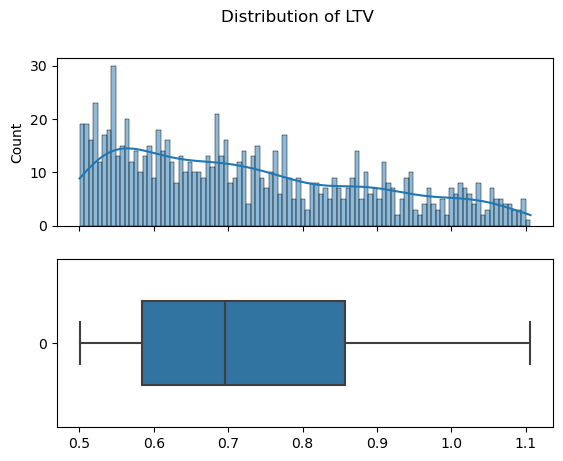

In [5]:
import warnings
warnings.filterwarnings('ignore')
fig, ax = plt.subplots(2, 1, sharex=True)
fig.suptitle('Distribution of LTV')
sns.histplot(ltv1, bins=100, legend=False, kde=True, ax=ax[0])
sns.boxplot(ltv1, orient='h', ax=ax[1], width=.5)
plt.show()

## 2. Identify relationship between LTV and Default

Since **Default in 12 Months** is a binomial variable, we can use a Logistic Regression model to predict the probability of default (PD) based on LTV.

In [6]:
import statsmodels.api as sm
X = ltv1
y = data['Default in 12 Months']
X = sm.add_constant(X)
model = sm.Logit(y, X)
result = model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.237277
         Iterations 7
                            Logit Regression Results                            
Dep. Variable:     Default in 12 Months   No. Observations:                  939
Model:                            Logit   Df Residuals:                      937
Method:                             MLE   Df Model:                            1
Date:                  Sun, 19 May 2024   Pseudo R-squ.:                0.001194
Time:                          14:15:23   Log-Likelihood:                -222.80
converged:                         True   LL-Null:                       -223.07
Covariance Type:              nonrobust   LLR p-value:                    0.4655
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -3.1118      0.603     -5.163      0.000      -4.29

#### Regression formula: 
\begin{align}
log \frac {PD}{1 - PD} = -3.1118 + 0.5819 * LTV
\end{align}


#### Model robustness:
- A Pseudo $R^2$ of *0.001194* indicates that the model has a very low goodness of fit. 

- With the coefficient's p-value of *0.463*, LTV is not statistically significant at the 5% significance level.

### Conclusion:

Although it is not unusual to use LTV as an indicator of PD, the above analysis shows that this variable is not a strong one. Instead of relying solely on LTV, it is suggested that multiple criteria should be considered especially those that are more closely related to an applicant's ability to repay their mortgage loans. Examples include but not limited to stability of disposable income, number of credit lines opened, history of credit card payment, etc.

It should also be noted that the above analysis was performed on a small sample and thus, may not be representative. An analysis with a larger dataset is recommended.